# 加载所需模块

`pandas`  `numpy`  `sklearn`  `matplotlib`  `seaborn`  `xgboost`

In [1]:
import os
#数据处理
import pandas as pd
import numpy as np
import random
import sklearn.preprocessing as preprocessing
#可视化
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

In [13]:
path = 'D:/deaplearning/'
train = pd.read_csv(path + 'Titanic_train.csv')
test = pd.read_csv(path + 'Titanic_test.csv')
all_train = pd.concat((train.drop(['Survived'],axis=1),
                     test)).loc[:,'Pclass':'Embarked']
train.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
256,257,1,1,"Thorne, Mrs. Gertrude Maybelle",female,NaN,0,0,PC 17585,79.2000,NaN,C
380,381,1,1,"Bidois, Miss. Rosalie",female,42.0,0,0,PC 17757,227.5250,NaN,C
596,597,1,2,"Leitch, Miss. Jessie Wills",female,NaN,0,0,248727,33.0000,NaN,S
668,669,0,3,"Cook, Mr. Jacob",male,43.0,0,0,A/5 3536,8.0500,NaN,S
223,224,0,3,"Nenkoff, Mr. Christo",male,NaN,0,0,349234,7.8958,NaN,S
207,208,1,3,"Albimona, Mr. Nassef Cassem",male,26.0,0,0,2699,18.7875,NaN,C
844,845,0,3,"Culumovic, Mr. Jeso",male,17.0,0,0,315090,8.6625,NaN,S
57,58,0,3,"Novel, Mr. Mansouer",male,28.5,0,0,2697,7.2292,NaN,C
163,164,0,3,"Calic, Mr. Jovo",male,17.0,0,0,315093,8.6625,NaN,S
215,216,1,1,"Newell, Miss. Madeleine",female,31.0,1,0,35273,113.2750,D36,C


载入数据后随机取10个样本查看，共12个特征：
## 注：存活率为38.4% 正负样本不均衡
> PassengerId：乘客ID

> Survived: 是否存活 

> Pclass: 乘客舱位（分别为1/2/3）

> Name: 名字

> Sex: 性别

> Age: 年龄

> SibSp: 堂兄弟/妹个数

> Parch: 父母与小孩的个数

> Ticket：船票信息

> Fare: 票价

> Cabin：客舱

> Embarked: 登岸港口

在训练中，丢掉无用的Survived和ID项

In [15]:
all_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 10 columns):
Pclass      1309 non-null int64
Name        1309 non-null object
Sex         1309 non-null object
Age         1046 non-null float64
SibSp       1309 non-null int64
Parch       1309 non-null int64
Ticket      1309 non-null object
Fare        1308 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 112.5+ KB


年龄与客舱有较多缺失值，登岸港口有2个缺失值，其余特征完整

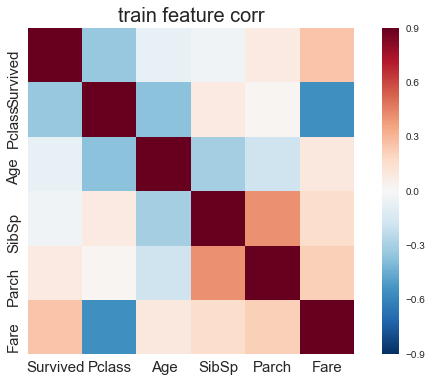

In [16]:
sns.set(context="paper", font="monospace")
sns.set(style="white")
f, ax = plt.subplots(figsize=(10,6))
train_corr = train.drop('PassengerId',axis=1).corr()
sns.heatmap(train_corr, ax=ax, vmax=.9, square=True)
ax.set_xticklabels(train_corr.index, size=15)
ax.set_yticklabels(train_corr.columns[::-1], size=15)
ax.set_title('train feature corr', fontsize=20)

简单观察可以得出结论：
- Fare票价与是否存活正相关
- Pclass与Fare负相关 与是否存活负相关

票价越高（越有钱）越容易存活，舱位越小，越有钱，越容易存活

### AGE与是否存活的关系

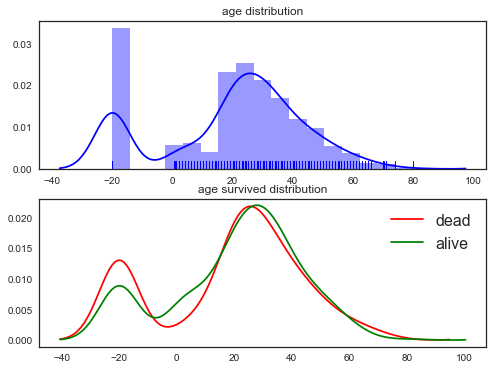

In [17]:
from scipy import stats
fig, axes = plt.subplots(2,1,figsize=(8,6))
sns.set_style('white')
sns.distplot(train.Age.fillna(-20), rug=True, color='b', ax=axes[0])
ax0 = axes[0]
ax0.set_title('age distribution')
ax0.set_xlabel('')

ax1 = axes[1]
ax1.set_title('age survived distribution')
k1 = sns.distplot(train[train.Survived==0].Age.fillna(-20), hist=False, color='r', ax=ax1, label='dead')
k2 = sns.distplot(train[train.Survived==1].Age.fillna(-20), hist=False, color='g', ax=ax1, label='alive')
ax1.set_xlabel('')

ax1.legend(fontsize=16)

缺失年龄用-20填充
- 年龄分布在20\-40，像高斯分布
- 年龄缺失的死亡人数比不缺失的要多（遇难者的信息不好统计？）可以考虑将年龄是否缺失作为一个特征
- 年龄越小越容易获救（集中在20岁附近）

以10岁为一个单位将年龄量化，统计每个区间的存活与死亡的情况

In [52]:
def Quantization_age(x):
    '''
    量化年龄
    '''
    if np.isnan(x):
        return 0
    elif (x<=60)&(x>0):
        return int(np.floor(x/10))
    else :
        return 7

In [56]:
train['Q_age'] = train['Age'].apply(Quantization_age)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Q_age
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,3


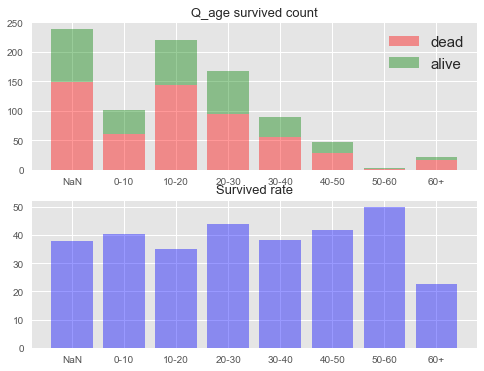

In [63]:
plt.style.use('ggplot')
f, ax = plt.subplots(2,1,figsize=(8,6))
pos = [1, 2, 3, 4, 5, 6, 7, 8]
y1 = train[train.Survived==0].groupby('Q_age')['Survived'].count().sort_index().values
y2 = train[train.Survived==1].groupby('Q_age')['Survived'].count().sort_index().values
ax[0].bar(pos, y1, color='r', alpha=0.4, align='center', label='dead')
ax[0].bar(pos, y2, color='g', alpha=0.4, align='center', label='alive', bottom=y1)
ax[0].set_xticks(pos)
ax[0].set_xticklabels(['NaN','0-10','10-20','20-30','30-40','40-50','50-60','60+'])
ax[0].legend(fontsize=15, loc='best')
ax[0].set_title('Q_age survived count', size=13)
ax[1].bar(pos, 100*y2/(y1+y2), color='b', alpha=0.4, align='center')
ax[1].set_xticks(pos)
ax[1].set_xticklabels(['NaN','0-10','10-20','20-30','30-40','40-50','50-60','60+'])
ax[1].set_title('Survived rate', size=13)

以38.4%为基准。
- 缺失，30-40岁在基准附近
- 0-10,20-30,50-60高于基准，但应考虑到50-60人数过少
- 60+，10-20低于基准

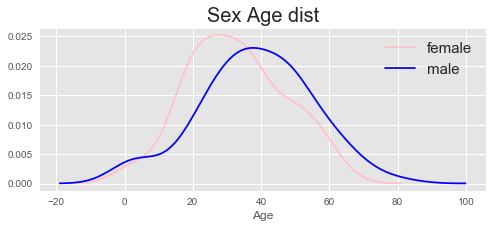

In [69]:
f, ax = plt.subplots(figsize=(8,3))
ax.set_title('Sex Age dist', size=20)
sns.distplot(train[train.Sex=='female'].dropna().Age, hist=False, color='pink', label='female')
sns.distplot(train[train.Sex=='male'].dropna().Age, hist=False, color='blue', label='male')
ax.legend(fontsize=15)

男人年纪偏大

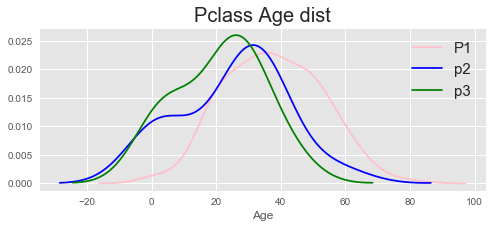

In [70]:
f, ax = plt.subplots(figsize=(8,3))
ax.set_title('Pclass Age dist', size=20)
sns.distplot(train[train.Pclass==1].dropna().Age, hist=False, color='pink', label='P1')
sns.distplot(train[train.Pclass==2].dropna().Age, hist=False, color='blue', label='p2')
sns.distplot(train[train.Pclass==3].dropna().Age, hist=False, color='g', label='p3')
ax.legend(fontsize=15)

年纪越大，舱位越好（越有钱）